# Análisis del Sentimiento de las noticias económicas en Chile 2020

Este es un trabajo en progreso. La base de datos es pequeña, por lo que no se espera obtener resultados excelentes. Este análisis se irá actualizando a medida que vaya obteniendo más datos para el análisis.

En primer lugar importo los paquetes a utilizar en los análisis.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import unidecode

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Embedding, GlobalAveragePooling1D, GlobalMaxPool1D, LSTM
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import json

Luego cargo los datos y los examino brevemente.

La base de datos contiene una serie de variables, además de las noticias. Se registra el mes y año en que se publicó, el sentimiento (sentimiento/response) que puede ser negativo, neutral o positivo, y el texto de la noticia. Además se observan otras dos variables: fuente y empresa. Su presencia se explica debido a que también se han recopilado fragmentos de textos de las memorias corporativas de empresas en Chile, que también contienen textos con significado económico. En este análisis se considerarán sólo las noticias económicas.

In [8]:
pd.set_option('display.max_columns', 20) # número máximo de columnas a mostrar en el terminal
pd.set_option('display.max_rows', 100) # número máximo de filas a mostrar en el terminal

dataset = pd.read_csv('Sentimientos.csv')
dataset = dataset[dataset['fuente'] != 'memoria']
dataset = dataset.dropna().reset_index(drop=True)
dataset.head()

,month,year,fuente,sentimiento,response,empresa,texto
0,4,2020.0,noticia,negativo,-1.0,.,Economía global anotaría en 2020 su peor año d...
1,4,2020.0,noticia,negativo,-1.0,.,Goldman Sachs prevé una crisis cuatro veces pe...
2,4,2020.0,noticia,positivo,1.0,.,Amazon logra su máxima cotización histórica en...
3,4,2020.0,noticia,negativo,-1.0,.,"Sin embargo, este incremento súbito del volume..."
4,4,2020.0,noticia,positivo,1.0,.,Venta online de productos para mascotas aument...


En la siguiente celda muestro la composición de la base de datos. El 71% de las noticias son negativas, el 16% son neutrales y el 13% son positivias.

In [9]:
dataset0 = dataset.copy()
dataset['response'].value_counts(normalize=True)

-1.0    0.711864
 0.0    0.158596
 1.0    0.129540
Name: response, dtype: float64

En este análisis se trabajará sólo con noticias positivas y negativas. Se excluyen las noticias neutrales.

In [10]:
dataset = dataset.drop(dataset[dataset['response'] == 0].index)
dataset = dataset.reset_index(drop=True)
dataset['response'] = dataset['response'].replace(-1, 0)
dataset['response'].value_counts(normalize=True)

0.0    0.846043
1.0    0.153957
Name: response, dtype: float64

De esta manera, la base de datos termina con 695 noticias económicas, lo que es una muestra pequeña, sobre todo para el caso de las redes neuronales.

In [11]:
print('Dimensiones de los datos: \n', dataset.shape, '\n')
print(dataset.info())

Dimensiones de los datos: 
 (695, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month        695 non-null    object 
 1   year         695 non-null    float64
 2   fuente       695 non-null    object 
 3   sentimiento  695 non-null    object 
 4   response     695 non-null    float64
 5   empresa      695 non-null    object 
 6   texto        695 non-null    object 
dtypes: float64(2), object(5)
memory usage: 38.1+ KB
None


En la siguiente celda se muestra que la noticia más larga contiene 2.403 palabras, mientras que la más corta contiene 45 palabras.

In [12]:
x = []
for e in dataset['texto']:
    x.append(len(e.split()))
print('Número de palabras de la noticia más larga: \n',  max(x), '\n')
print('Número de palabras de la noticia más corta: \n',  min(x), '\n')

Número de palabras de la noticia más larga: 
 2403 

Número de palabras de la noticia más corta: 
 45 



En la siguiente celda se muestra un ejemplo de noticia seleccionada al azar.

In [13]:
data = dataset['texto']

In [15]:
k = np.random.randint(0, len(data))
print('Noticia %d :' % k, '\n', data[k])

Noticia 603 : 
 La empresa chilena NotCo, firma líder en tecnología de alimentos en América Latina, cerró una ronda de financiación de capital, logrando recaudar unos US$85 millones y se convirtió en la startup con mayor inversión extranjera en Chile, según CB Insights. "Esta ronda de financiamiento no hace más que confirmar que vamos por buen camino y de paso, incentivarnos a seguir trabajando en beneficio de la salud de las personas como también del planeta, pero de una manera deliciosa y revolucionaria pensada en el largo plazo", expresó sostiene Matías Muchnick, CEO y cofundador de NotCo. Noticias relacionadas Foro Económico Mundial destaca a empresa chilena entre los "100 Pioneros tecnológicos": "Es la consolidación de un sueño" Foro Económico Mundial destaca a empresa chilena entre los "100 Pioneros tecnológicos": "Es la consolidación de un sueño" Fundador de Amazon y hombre más rico del mundo invierte en startup chilena de comida en base a plantas Fundador de Amazon y hombre más

# Preprocesamiento de los datos
En la siguientes celda se hace un preprocesamiento de los datos, para estructuralos, de forma de obtener una base de datos que se pueda utilizar en los algoritmos de machine learning. Este preprocesamiento servirá para dos modelos: Regresión logística y Red neuronal artificial.

En primer preprocesamiento consiste en poner las palabras en minúsculas, eliminar los números y carácteres especiales de los textos, y se retiran las stopwords y los acentos. 

In [16]:
sw = pd.read_csv('spanish.txt', header=None, names=['stopwords'])
stopwords = sw['stopwords'].tolist()

In [17]:
def preprocess(s):
    s = s.lower()
    s = re.sub('[0-9]+', '', s) 
    s = re.sub('[!"#$%&()*+,-./:;<=>¿?@[\\]^_`{|}~\t—’‘“”]', '', s)
    tokens = nltk.tokenize.word_tokenize(s) 
    tokens = [t for t in tokens if t not in stopwords] 
    tokens = [unidecode.unidecode(t) for t in tokens]
    jtokens = ' '.join(tokens)
    return jtokens

pdata = [preprocess(t) for t in data]

En la siguiente celda se muestra la misma noticia anterior preprocesada.

In [18]:
print('Noticia %d :' % k, '\n', pdata[k])

Noticia 603 : 
 empresa chilena notco firma lider tecnologia alimentos america latina cerro ronda financiacion capital logrando recaudar us millones convirtio startup mayor inversion extranjera chile segun cb insights ronda financiamiento hace confirmar vamos buen camino paso incentivarnos seguir trabajando beneficio salud personas planeta manera deliciosa revolucionaria pensada largo plazo expreso sostiene matias muchnick ceo cofundador notco noticias relacionadas foro economico mundial destaca empresa chilena pioneros tecnologicos consolidacion sueno foro economico mundial destaca empresa chilena pioneros tecnologicos consolidacion sueno fundador amazon hombre rico mundo invierte startup chilena comida base plantas fundador amazon hombre rico mundo invierte startup chilena comida base plantas compania utiliza inteligencia artificial descubrir nuevas alternativas basadas plantas productos alimenticios mayonesa leche queso financiamiento logrado ronda apoyara consolidacion operaciones 

Luego se verifica cómo cambió la noticia más larga y la más corta luego del preprocesamiento. Se observa una reducción importante de palabras.

In [19]:
x = []
for e in pdata:
    x.append(len(e.split()))
print('Número de palabras de la noticia más larga: \n',  max(x), '\n')
print('Número de palabras de la noticia más corta: \n',  min(x), '\n')

Número de palabras de la noticia más larga: 
 1161 

Número de palabras de la noticia más corta: 
 20 



El siguiente paso es vectorizar, para lo cual se usa el método CountVectorizer de SKLearn. Se establece un máximo de 2500 palabras y se usan ngrams de 1 y 2 palabras. Este método cuenta el número de veces que aparece cada palabra del vocabulario en cada texto.

In [20]:
vect = CountVectorizer(max_features=2500, ngram_range=(1,2))
vdat = vect.fit_transform(pdata)
vdata = pd.DataFrame(vdat.toarray(), columns=vect.get_feature_names())
print(vdata.shape)

(695, 2500)


Así ha quedado la base de datos.

In [21]:
print(vdata.head())

abcdin  abril  abril junio  abril mayo  abriljunio  abrir  aca  academico  \
0       0      0            0           0           0      0    0          0   
1       0      1            0           1           0      0    0          0   
2       0      0            0           0           0      0    0          0   
3       0      0            0           0           0      0    0          0   
4       0      0            0           0           0      0    0          0   

   acceder  acceso  ...  wall  wall street  walmart  web  wti  york  zaldivar  \
0        0       0  ...     0            0        0    0    0     0         0   
1        0       0  ...     0            0        0    0    0     0         0   
2        0       0  ...     0            0        0    0    0     1         0   
3        0       0  ...     0            0        0    1    0     0         0   
4        0       0  ...     0            0        0    1    0     0         0   

   zona  zona euro  zonas  
0     0

Luego se define la variable dependiente *y*, y los predictores *X*.

In [22]:
y = dataset['response']
X = vdata

Se dividen los datos en un set de entrenamiento y otro de testeo.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

Finalmente, se estandarizan los datos, usando los parámetros del training set. Esto se hace luego de la división de los datos para evitar contaminar el testing set con información del training set.

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
nX_train = scaler.transform(X_train)
nX_train = pd.DataFrame(nX_train, columns=X_train.columns)

nX_test = scaler.transform(X_test)
nX_test = pd.DataFrame(nX_test, columns=X_test.columns)

# Regresión Logística
El primer modelo a probar. Se trata de un modelo sencillo que servirá de benchmark para los demás.

Los modelos se evaluarán en base a 3 medidas: accuracy, ROC AUC y F1 Score.

In [64]:
model = LogisticRegression(random_state=123)
parameters = {'C':[1, 100, 500, 1000, 5000, 10000, 12500, 25000], 
              'penalty':['l1', 'l2']}
searcher = GridSearchCV(estimator=model, 
                        param_grid=parameters, 
                        n_jobs=-1, 
                        verbose=1)
searcher.fit(nX_train, y_train)
print("Best CV params", searcher.best_params_)

best_model = searcher.best_estimator_
y_pred = best_model.predict(nX_test)
y_pred_proba = best_model.predict_proba(nX_test)[:,1]

Accuracy1 = accuracy_score(y_test, y_pred)
ROC_AUC1 = roc_auc_score(y_test, y_pred_proba)
F1Score1 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy1)
print("Area Under the ROC Curve:", ROC_AUC1)
print("F1 Score:", F1Score1)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.6s finished


Best CV params {'C': 1000, 'penalty': 'l2'}
Test accuracy of best CV params: 0.9043062200956937
Area Under the ROC Curve: 0.957274011299435
F1 Score: 0.6551724137931033


Se observa que la regresión logística obtuvo un excelente desempeño, lo que es muy bueno, considerando que permite obtener coeficientes interpretables.

A continuación se muestran los coeficientes más bajos y más altos, que se pueden interpretar como las palabras más negativas y más positivas, respectivamente.

In [65]:
coeficientes =  pd.DataFrame(best_model.coef_, columns=X_train.columns, index=['Coeficientes'])
coeficientes = coeficientes.T
coeficientes = coeficientes.sort_values('Coeficientes')
print(coeficientes.head(10))
print(coeficientes.tail(10))

                         Coeficientes
perdio                      -0.336897
impacto                     -0.239861
bajaron                     -0.229538
millones millones           -0.227841
sostuvo                     -0.225835
pandemia coronavirus        -0.221591
impacto pandemia            -0.214897
debido                      -0.211046
primera vez                 -0.210509
perspectivas economicas     -0.208365
                 Coeficientes
elaborado            0.321472
compra               0.324783
lunes                0.327429
subio                0.344058
tecnologicos         0.376932
puntos               0.383296
economia pais        0.390556
alza                 0.395226
empresas sector      0.418715
supero               0.451120


# Red Neuronal Artificial
El segundo modelo es una red artificial tradicional, compuesta sólo de dense layers.

In [25]:
def get_model():
    model = Sequential([
                    Dense(128, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-5), activation='relu', input_shape=(X_train.shape[1],)),
                    BatchNormalization(),
                    Dense(128, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-5), activation='relu'),
                    Dropout(0.5),
                    Dense(64, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-5), activation='relu'),
                    BatchNormalization(),
                    Dense(64, kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(1e-5), activation='relu'),
                    Dropout(0.5),
                    Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

El resumen del modelo muestra que tiene 349.889 parámetros entrenables, lo que es mucho para una base de datos tan pequeña, por lo que se espera overfitting.

In [26]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               320128    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4

Durante el entrenamiento se irán guardando los weights que produzcan el mejor desempeño.

In [27]:
checkpoint_best_path = 'C:/Users/acuna/OneDrive/Documents/Callbacks/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1
                                 )
history = model.fit(nX_train, y_train, epochs=20, validation_data=(nX_test, y_test), batch_size=64, callbacks=[checkpoint_best])

Epoch 1/20
7/8 [=========================>....] - ETA: 0s - loss: 0.7318 - accuracy: 0.6719 - auc: 0.5578
Epoch 00001: val_accuracy improved from -inf to 0.78469, saving model to C:/Users/acuna/OneDrive/Documents/Callbacks\checkpoint
8/8 [==============================] - 1s 120ms/step - loss: 0.7093 - accuracy: 0.6790 - auc: 0.5651 - val_loss: 0.5532 - val_accuracy: 0.7847 - val_auc: 0.5428
Epoch 2/20
7/8 [=========================>....] - ETA: 0s - loss: 0.5673 - accuracy: 0.7478 - auc: 0.6188
Epoch 00002: val_accuracy improved from 0.78469 to 0.80861, saving model to C:/Users/acuna/OneDrive/Documents/Callbacks\checkpoint
8/8 [==============================] - 0s 21ms/step - loss: 0.5606 - accuracy: 0.7510 - auc: 0.6273 - val_loss: 0.5014 - val_accuracy: 0.8086 - val_auc: 0.6255
Epoch 3/20
7/8 [=========================>....] - ETA: 0s - loss: 0.4882 - accuracy: 0.8058 - auc: 0.6806
Epoch 00003: val_accuracy improved from 0.80861 to 0.83254, saving model to C:/Users/acuna/OneDrive/Do

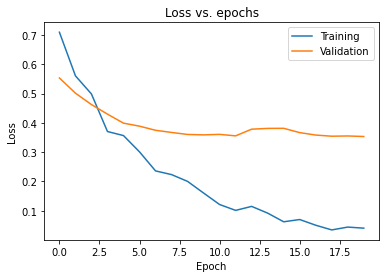

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

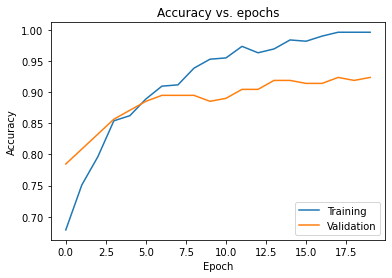

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

En los gráficos anteriores se observa que el overfitting no fue tan terrible. 

A continuación se cargan los weights del mejor modelo registrado.

In [30]:
best_model = get_model()
best_model.load_weights(checkpoint_best_path)

El desempeño obtenido es algo mejor que el logrado por la regresión logística.

In [31]:
y_pred_proba = best_model.predict(nX_test)
y_pred = (y_pred_proba > 0.5)*1

Accuracy2 = accuracy_score(y_test, y_pred)
ROC_AUC2 = roc_auc_score(y_test, y_pred_proba)
F1Score2 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy2)
print("Area Under the ROC Curve:", ROC_AUC2)
print("F1 Score:", F1Score2)

Test accuracy of best CV params: 0.9234449760765551
Area Under the ROC Curve: 0.9288488700564973
F1 Score: 0.7575757575757576


# Modelos de Secuencias: preprocesamiento
A continuación se repite el ejercicio utilizando modelos de secuencias, para lo cual debe preprocesarse la base de datos de una manera distinta.

En primer lugar se utiliza el Tokenizer de Tensorflow. Se eliminan los carácteres extraños y se asigna un token para las palabras desconocidas. Se menciona que este Tokenizer se aplica a la base de datos preprocesada en la sección anterior, antes de ser vectorizada (sólo se le aplico la función preprocess), para que los textos sean más comparables entre los distintos análisis. Los textos son transformados a secuencias, donde cada palabra es reemplazada por el número de palabra asignado en un  diccionario que registra todas las palabras del vocabulario.

In [151]:
additional_filters = '—’‘“”'
tokenizer = Tokenizer(num_words=None, 
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' + additional_filters,
                      oov_token='<UNK>')
tokenizer.fit_on_texts(pdata)

In [152]:
tdata = tokenizer.texts_to_sequences(pdata)

A continuación se ilustra como un texto fue transformado en secuencia.

In [153]:
print(pdata[1], '\n')
print(tdata[1], '\n')

goldman sachs preve crisis cuatro veces peor eeuu gobiernos nivel mundial deben amortiguar posible impacto ingresos sector privado concluyo banco estadounidense banco estadounidense goldman sachs advirtio martes espera unidos crisis economica derivada pandemia covid cuatro veces peor senalo cifras desempleo podrian ser similares sufrio pais segunda guerra mundial nota clientes recogida medios locales banco apunta embargo podria dar recuperacion economica precedentes sentido goldman sachs situa disminucion producto interior bruto pib estadounidense segundo trimestre respecto ano anterior caida mayor cualquiera experimentadas gran crisis decada pasada ademas tasa desempleo podria alcanzar segun compania financiera advierte posible debido gravedad situacion trabajadores queden marginados busquen empleo reapertura anticipada economia respecto recuperacion banco augura podria ser posible recuperar menos parte produccion perdida si lleva cabo fuerte aumento test asi cambios practicas comerci

Luego se guardan dos diccionarios, uno que transforma los número a palabras y viceversa. En la siguiente celda se aplica el diccionario a la secuencia anterior, y se verifica cómo se recupera el texto original a partir de la secuencia.

In [154]:
tokenizer_config = tokenizer.get_config()
index_word = json.loads(tokenizer_config['index_word'])
word_index = json.loads(tokenizer_config['word_index'])

In [155]:
trad = [index_word[str(e)] for e in tdata[1]]
print(trad)

['goldman', 'sachs', 'preve', 'crisis', 'cuatro', 'veces', 'peor', 'eeuu', 'gobiernos', 'nivel', 'mundial', 'deben', 'amortiguar', 'posible', 'impacto', 'ingresos', 'sector', 'privado', 'concluyo', 'banco', 'estadounidense', 'banco', 'estadounidense', 'goldman', 'sachs', 'advirtio', 'martes', 'espera', 'unidos', 'crisis', 'economica', 'derivada', 'pandemia', 'covid', 'cuatro', 'veces', 'peor', 'senalo', 'cifras', 'desempleo', 'podrian', 'ser', 'similares', 'sufrio', 'pais', 'segunda', 'guerra', 'mundial', 'nota', 'clientes', 'recogida', 'medios', 'locales', 'banco', 'apunta', 'embargo', 'podria', 'dar', 'recuperacion', 'economica', 'precedentes', 'sentido', 'goldman', 'sachs', 'situa', 'disminucion', 'producto', 'interior', 'bruto', 'pib', 'estadounidense', 'segundo', 'trimestre', 'respecto', 'ano', 'anterior', 'caida', 'mayor', 'cualquiera', 'experimentadas', 'gran', 'crisis', 'decada', 'pasada', 'ademas', 'tasa', 'desempleo', 'podria', 'alcanzar', 'segun', 'compania', 'financiera', '

En la siguiente celda se muestra el largo de las secuencias más larga y más corta. Se verifica que el resultado es igual al obtenido en el preprocesamiento anterior.

In [156]:
x = []
for e in tdata:
    x.append(len(e))
print('Secuencia más larga: \n', max(x), '\n')
print('Secuencia más corta: \n', min(x), '\n')

Secuencia más larga: 
 1161 

Secuencia más corta: 
 20 



Luego se procede a aplicar padding a las secuencias. El padding máximo será igual al largo de la secuencia más larga (la secuencia más larga no tendrá padding), y se realizará al principio de las secuencias. En la siguiente celda se ilustra qué es el padding. Este método permite que todas las secuencias tengan el mismo largo.

In [157]:
padata = pad_sequences(tdata, maxlen=1161, padding='pre')
padata.shape

(695, 1161)

In [158]:
trad = [index_word[str(e)] if e!=0 else '0' for e in padata[1]]
print(trad)

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',

En las celdas siguientes se divide la muestra en sets de entrenamiento y testeo, usando los mismos índices que en la separación anterior. Así, los resultados serán comparables.

In [221]:
train_sample = y_train.index
test_sample = y_test.index

In [252]:
X_train = padata[train_sample]
X_test = padata[test_sample]
print(X_train.shape)
print(X_test.shape)

(486, 1161)
(209, 1161)


# Red Neuronal con embeddings
El primer modelo de secuencias será una red neuronal sencilla, con embeddings, y 456.353 parámteros entrenables. Al igual que en la sección anterior se guardan los parámetros del mejor modelo obtenido durante el entrenamiento.

In [331]:
def get_model():
    max_index_value = max(word_index.values())
    embedding_dim = 32
    model = tf.keras.Sequential([
        Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, 
                  embeddings_regularizer=regularizers.l2(1e-5), mask_zero=False),
        GlobalMaxPool1D(),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

In [332]:
model = get_model()
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, None, 32)          456192    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 32)                0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 32)                128       
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 33        
Total params: 456,353
Trainable params: 456,289
Non-trainable params: 64
_________________________________________________________________


In [333]:
checkpoint_best_path = 'C:/Users/acuna/OneDrive/Documents/Callbacks/checkpoint_embedding'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1
                                 )
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64, callbacks=[checkpoint_best])

Epoch 1/20
7/8 [=========================>....] - ETA: 0s - loss: 0.6831 - accuracy: 0.6094 - auc: 0.6554
Epoch 00001: val_accuracy improved from -inf to 0.84689, saving model to C:/Users/acuna/OneDrive/Documents/Callbacks\checkpoint_embedding
8/8 [==============================] - 1s 86ms/step - loss: 0.6821 - accuracy: 0.6132 - auc: 0.6563 - val_loss: 0.6676 - val_accuracy: 0.8469 - val_auc: 0.6388
Epoch 2/20
7/8 [=========================>....] - ETA: 0s - loss: 0.5956 - accuracy: 0.8348 - auc: 0.9902
Epoch 00002: val_accuracy did not improve from 0.84689
8/8 [==============================] - 0s 32ms/step - loss: 0.5946 - accuracy: 0.8333 - auc: 0.9908 - val_loss: 0.6440 - val_accuracy: 0.8469 - val_auc: 0.7952
Epoch 3/20
7/8 [=========================>....] - ETA: 0s - loss: 0.5268 - accuracy: 0.8705 - auc: 0.9973
Epoch 00003: val_accuracy did not improve from 0.84689
8/8 [==============================] - 0s 32ms/step - loss: 0.5219 - accuracy: 0.8704 - auc: 0.9976 - val_loss: 0.

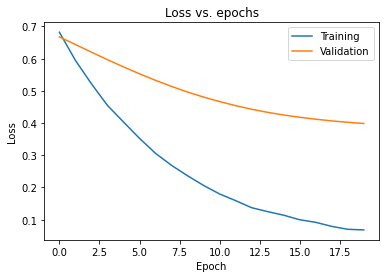

In [334]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

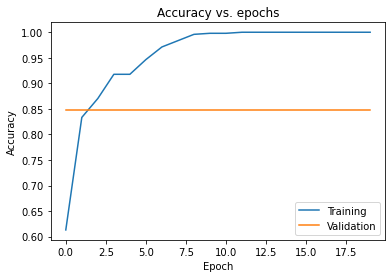

In [335]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [336]:
best_model = get_model()
best_model.load_weights(checkpoint_best_path)

Se observa un F1 Score de 0, lo que junto al gráfico de Accuracy vs Epochs sugiere que hubo algún problema. Probablemente la red neuronal está prediciendo que todos los textos son negativos.

In [337]:
y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5)*1

Accuracy3 = accuracy_score(y_test, y_pred)
ROC_AUC3 = roc_auc_score(y_test, y_pred_proba)
F1Score3 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy3)
print("Area Under the ROC Curve:", ROC_AUC3)
print("F1 Score:", F1Score3)

Test accuracy of best CV params: 0.84688995215311
Area Under the ROC Curve: 0.8132062146892655
F1 Score: 0.0


A continuación se guardan los pesos de la matriz de embeddings para visualizarlos en el proyector de embeddings de Tensorflow. 

In [59]:
weights = best_model.layers[0].get_weights()[0]

The Tensorflow embedding projector can be found [here](https://projector.tensorflow.org/).

In [341]:
import io
from os import path

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

k = 0

for word, token in word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()

# Recurrent Neural Network
El último modelo testeado es un red neuronal recurrente, con neuronas LSTM y matriz de embeddings. Este modelo tiene 481.089 parámetros entrenables, y al igual que en los casos anteriores se guarda el mejor modelo obtenido durante en entrenamiento.

In [338]:
def get_model():
    max_index_value = max(word_index.values())
    embedding_dim = 32
    model = tf.keras.Sequential([
        Embedding(input_dim=max_index_value+1, output_dim=embedding_dim,
                  embeddings_regularizer=regularizers.l2(1e-5), mask_zero=True),
        LSTM(units=64, kernel_regularizer=regularizers.l2(1e-5), dropout=0.25),
        Dense(units=1, activation='sigmoid'),
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    return model

In [339]:
model = get_model()
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, None, 32)          456192    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 65        
Total params: 481,089
Trainable params: 481,089
Non-trainable params: 0
_________________________________________________________________


In [340]:
checkpoint_best_path = 'C:/Users/acuna/OneDrive/Documents/Callbacks/checkpoint_rnn'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1
                                 )
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=64, callbacks=[checkpoint_best])

Epoch 1/20


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


8/8 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.7860 - auc: 0.4448
Epoch 00001: val_accuracy improved from -inf to 0.84689, saving model to C:/Users/acuna/OneDrive/Documents/Callbacks\checkpoint_rnn
8/8 [==============================] - 11s 1s/step - loss: 0.6785 - accuracy: 0.7860 - auc: 0.4448 - val_loss: 0.6306 - val_accuracy: 0.8469 - val_auc: 0.6773
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.5353 - accuracy: 0.8457 - auc: 0.5245
Epoch 00002: val_accuracy did not improve from 0.84689
8/8 [==============================] - 9s 1s/step - loss: 0.5353 - accuracy: 0.8457 - auc: 0.5245 - val_loss: 0.4472 - val_accuracy: 0.8469 - val_auc: 0.6772
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.8457 - auc: 0.5927
Epoch 00003: val_accuracy did not improve from 0.84689
8/8 [==============================] - 8s 1s/step - loss: 0.4325 - accuracy: 0.8457 - auc: 0.5927 - val_loss: 0.4314 - val_accuracy: 0

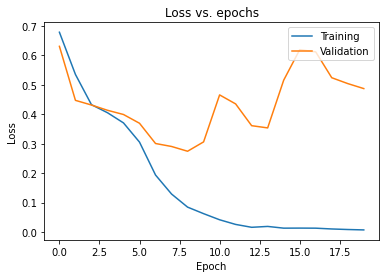

In [341]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

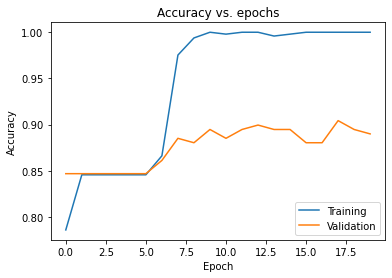

In [342]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

In [343]:
best_model = get_model()
best_model.load_weights(checkpoint_best_path)

El resultado es decente pero no tan bueno como en casos anteriores, lo que se debe a que se produce mucho overfitting durante el entrenamiento. Este modelo (al igual que las otras redes neuronales) requiere una mayor cantidad de datos para funcionar bien.

In [344]:
y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5)*1

Accuracy4 = accuracy_score(y_test, y_pred)
ROC_AUC4 = roc_auc_score(y_test, y_pred_proba)
F1Score4 = f1_score(y_test, y_pred)
print("Test accuracy of best CV params:", Accuracy4)
print("Area Under the ROC Curve:", ROC_AUC4)
print("F1 Score:", F1Score4)

Test accuracy of best CV params: 0.9043062200956937
Area Under the ROC Curve: 0.8227401129943502
F1 Score: 0.5454545454545454
